In [219]:
!rm -rf /kaggle/working/*

In [220]:
'''
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()    
'''


'\n!pip install GPUtil\n\nimport torch\nfrom GPUtil import showUtilization as gpu_usage\nfrom numba import cuda\n\ndef free_gpu_cache():\n    print("Initial GPU Usage")\n    gpu_usage()                             \n\n    torch.cuda.empty_cache()\n\n    cuda.select_device(0)\n    cuda.close()\n    cuda.select_device(0)\n\n    print("GPU Usage after emptying the cache")\n    gpu_usage()\n\nfree_gpu_cache()    \n'

In [221]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn


In [222]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [223]:
import kagglehub
sperm_dataset = kagglehub.dataset_download('busragural/sperm-dataset')

In [224]:
data_dir = "/kaggle/input/sperm-dataset/train"

In [225]:
mean_file_count = 0
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f"Folder: {folder}, #File: {file_count}")
        mean_file_count += file_count

mean_file_count /= len(os.listdir(data_dir))
print(f"Mean #File: {mean_file_count}")

Folder: RounHead, #File: 77
Folder: CurlyTail, #File: 433
Folder: AsymmetricNeck, #File: 109
Folder: ThinNeck, #File: 57
Folder: TwistedNeck, #File: 346
Folder: NarrowAcrosome, #File: 616
Folder: ShortTail, #File: 297
Folder: PinHead, #File: 234
Folder: LongTail, #File: 12
Folder: ThickNeck, #File: 593
Folder: PyriformHead, #File: 293
Folder: Normal, #File: 179
Folder: DoubleHead, #File: 14
Folder: VacuolatedHead, #File: 509
Folder: AmorfHead, #File: 1071
Folder: DoubleTail, #File: 60
Folder: TwistedTail, #File: 211
Folder: TaperedHead, #File: 419
Mean #File: 307.22222222222223


In [226]:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [227]:
dataset = datasets.ImageFolder(root=data_dir)

In [228]:
import os
import shutil
import random
from collections import defaultdict

data_dir = "/kaggle/input/sperm-dataset/train"
train_dir = "/kaggle/working/balanced_train"
val_dir = "/kaggle/working/validation"
test_dir = "/kaggle/working/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)
        
        train_count = int(len(images) * split_ratios['train'])
        val_count = int(len(images) * split_ratios['val'])
        
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]
        
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
        
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dengeli Train-Test-Validation bölme tamamlandı!")


Dengeli Train-Test-Validation bölme tamamlandı!


In [229]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

min_class = min(class_counts.values())
max_class = max(class_counts.values())
target_count = int((min_class + max_class) / 2)
target_count = max_class
print(f"\nMinimum Class Count: {min_class}")
print(f"Maximum Class Count: {max_class}")
print(f"Target Class Count: {target_count}")



Minimum Class Count: 8
Maximum Class Count: 749
Target Class Count: 749


In [230]:
import torchvision.transforms as transforms
import random

class RandomSubsetTransform:
    def __init__(self, transforms_list, num_transforms=2):
        self.transforms_list = transforms_list
        self.num_transforms = num_transforms

    def __call__(self, img):
        selected_transforms = random.sample(self.transforms_list, self.num_transforms)
        for t in selected_transforms:
            img = t(img)
        return img

In [231]:
from torchvision.transforms.functional import resize

def super_resolution(img, target_size=(512, 512)):
    return img.resize(target_size, Image.BICUBIC)

In [232]:
from PIL import ImageOps

def rgb_to_lab(img):
    """
    RGB görüntüyü LAB renk uzayına dönüştürür.
    """
    return img.convert('LAB')


In [233]:
from PIL import Image,ImageFile, ImageFilter
from torchvision.transforms.functional import to_pil_image
import random
from torchvision import transforms

'''
# Augmentation Transform
augmentation_transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomGrayscale(p=0.1),
        #transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
    ]),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
'''

augmentation_transform = transforms.Compose([
    RandomSubsetTransform([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomAffine(degrees=0, shear=10),
        #transforms.RandomGrayscale(p=0.1),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
        #transforms.RandomInvert(p=0.2),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
        
        #transforms.Lambda(lambda img: super_resolution(img, target_size=(512, 512))),
        #transforms.Lambda(lambda img: img.filter(ImageFilter.SHARPEN)),
    ], num_transforms=3),  # Rastgele 2 dönüşüm uygulanacak
    #transforms.Lambda(lambda img: rgb_to_lab(img)),
    #transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])




# Oversampling işlemi
for class_name, count in class_counts.items():
    if count < target_count:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        
        needed_count = target_count - count
        print(f"{class_name}: {needed_count} image(s) will be generated.")
        
        for i in range(needed_count):
            random_image = random.choice(images)
            image_path = os.path.join(class_path, random_image)
            image = Image.open(image_path).convert('RGB')
            augmented_image = augmentation_transform(image)
            
            save_path = os.path.join(class_path, f"augmented_{i}.png")
            to_pil_image(augmented_image).save(save_path)

# Undersampling işlemi
for class_name, count in class_counts.items():
    if count > target_count:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        selected_images = random.sample(images, target_count)
        
        temp_dir = os.path.join(train_dir, f"undersampled_{class_name}")
        os.makedirs(temp_dir, exist_ok=True)
        
        for img in selected_images:
            shutil.move(os.path.join(class_path, img), os.path.join(temp_dir, img))
        
        # Eski klasörü sil ve yeni klasörü taşı
        shutil.rmtree(class_path)
        os.rename(temp_dir, class_path)
        
        print(f"{class_name}: reduced to {target_count} images.")

balanced_class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        balanced_class_counts[class_name] = len(os.listdir(class_path))

for class_name, count in balanced_class_counts.items():
    print(f"Class: {class_name}, Balanced Count: {count}")


NarrowAcrosome: 318 image(s) will be generated.
ThinNeck: 710 image(s) will be generated.
DoubleTail: 707 image(s) will be generated.
TwistedTail: 602 image(s) will be generated.
DoubleHead: 740 image(s) will be generated.
VacuolatedHead: 393 image(s) will be generated.
TaperedHead: 456 image(s) will be generated.
AsymmetricNeck: 673 image(s) will be generated.
PyriformHead: 544 image(s) will be generated.
TwistedNeck: 507 image(s) will be generated.
PinHead: 586 image(s) will be generated.
ThickNeck: 334 image(s) will be generated.
ShortTail: 542 image(s) will be generated.
CurlyTail: 446 image(s) will be generated.
LongTail: 741 image(s) will be generated.
Normal: 624 image(s) will be generated.
RounHead: 696 image(s) will be generated.
Class: NarrowAcrosome, Balanced Count: 749
Class: ThinNeck, Balanced Count: 749
Class: DoubleTail, Balanced Count: 749
Class: AmorfHead, Balanced Count: 749
Class: TwistedTail, Balanced Count: 749
Class: DoubleHead, Balanced Count: 749
Class: Vacuolat

In [234]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=val_test_transform)
val_dataset = datasets.ImageFolder(root='/kaggle/working/validation', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='/kaggle/working/test', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [48]:
model = models.mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features

model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(dataset.classes))
)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 117MB/s] 


In [235]:
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # %50 ihtimalle nöronları devre dışı bırak
    nn.Linear(num_features, len(dataset.classes))
)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

#criterion = FocalLoss(alpha=0.25, gamma=2).to(device)

loss_function = nn.CrossEntropyLoss()

model = model.to(device)


In [31]:
'''
from torchvision.models import efficientnet_b5

model = efficientnet_b5(pretrained=True)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(dataset.classes))

for param in model.parameters():
    param.requires_grad = True

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
criterion = nn.CrossEntropyLoss()
'''

'\nfrom torchvision.models import efficientnet_b5\n\nmodel = efficientnet_b5(pretrained=True)\n\nnum_features = model.classifier[1].in_features\nmodel.classifier[1] = nn.Linear(num_features, len(dataset.classes))\n\nfor param in model.parameters():\n    param.requires_grad = True\n\nmodel = model.to(device)\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\nscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)\ncriterion = nn.CrossEntropyLoss()\n'

In [236]:
# Eğitim, Doğrulama ve Test Döngüsü
def train_validate_test(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, epochs=10):
    train_losses, val_losses, test_losses = [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Scheduler adımını ilerlet
        scheduler.step()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Doğrulama Aşaması
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        # Test Aşaması
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    
    return train_losses, val_losses, test_losses


In [237]:
train_losses, val_losses, test_losses = train_validate_test(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, epochs=10
)

Epoch 1/10 - Train Loss: 1.5376, Val Loss: 1.4992, Test Loss: 1.4996
Learning Rate: 0.000100
Epoch 2/10 - Train Loss: 0.7202, Val Loss: 1.5046, Test Loss: 1.6044
Learning Rate: 0.000100
Epoch 3/10 - Train Loss: 0.4159, Val Loss: 1.4683, Test Loss: 1.5296
Learning Rate: 0.000010
Epoch 4/10 - Train Loss: 0.1527, Val Loss: 1.3419, Test Loss: 1.3877
Learning Rate: 0.000010
Epoch 5/10 - Train Loss: 0.0792, Val Loss: 1.4025, Test Loss: 1.4386
Learning Rate: 0.000010
Epoch 6/10 - Train Loss: 0.0507, Val Loss: 1.4841, Test Loss: 1.4939
Learning Rate: 0.000001
Epoch 7/10 - Train Loss: 0.0362, Val Loss: 1.4885, Test Loss: 1.5052
Learning Rate: 0.000001
Epoch 8/10 - Train Loss: 0.0340, Val Loss: 1.4821, Test Loss: 1.5116
Learning Rate: 0.000001
Epoch 9/10 - Train Loss: 0.0323, Val Loss: 1.4791, Test Loss: 1.4927
Learning Rate: 0.000000
Epoch 10/10 - Train Loss: 0.0300, Val Loss: 1.5074, Test Loss: 1.5080
Learning Rate: 0.000000


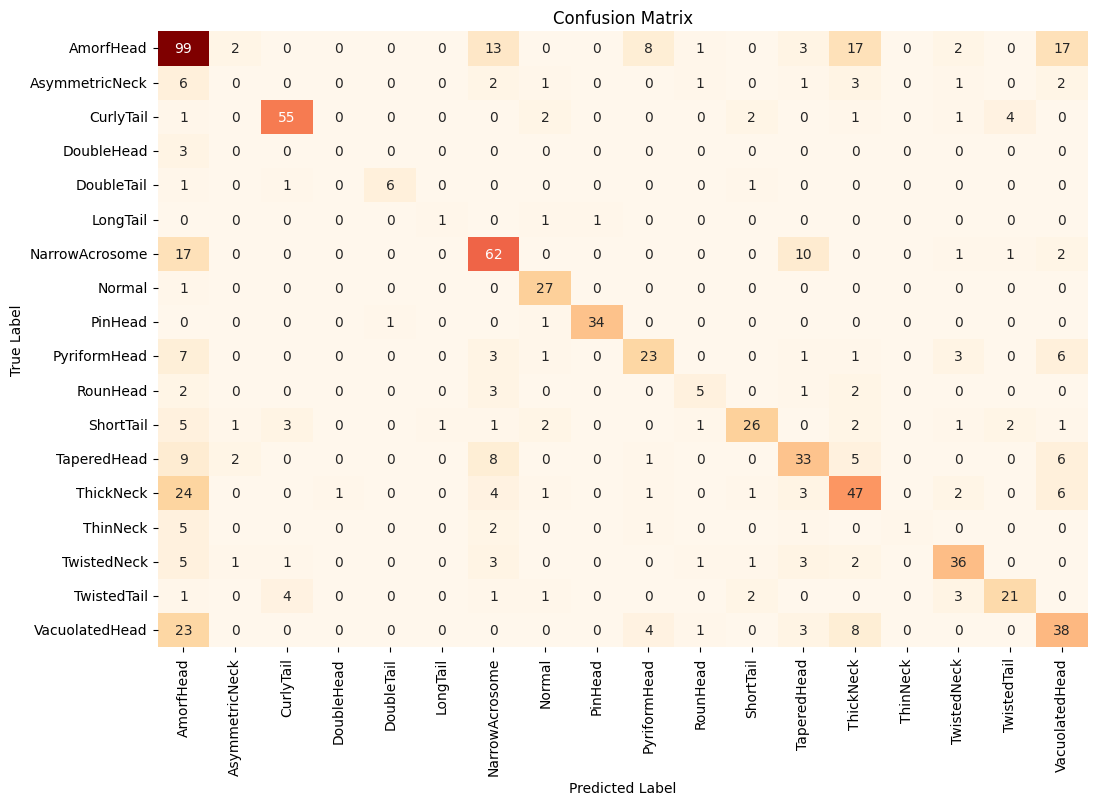


Classification Report:

                precision    recall  f1-score   support

     AmorfHead       0.47      0.61      0.53       162
AsymmetricNeck       0.00      0.00      0.00        17
     CurlyTail       0.86      0.83      0.85        66
    DoubleHead       0.00      0.00      0.00         3
    DoubleTail       0.86      0.67      0.75         9
      LongTail       0.50      0.33      0.40         3
NarrowAcrosome       0.61      0.67      0.64        93
        Normal       0.73      0.96      0.83        28
       PinHead       0.97      0.94      0.96        36
  PyriformHead       0.61      0.51      0.55        45
      RounHead       0.50      0.38      0.43        13
     ShortTail       0.79      0.57      0.66        46
   TaperedHead       0.56      0.52      0.54        64
     ThickNeck       0.53      0.52      0.53        90
      ThinNeck       1.00      0.10      0.18        10
   TwistedNeck       0.72      0.68      0.70        53
   TwistedTail       0

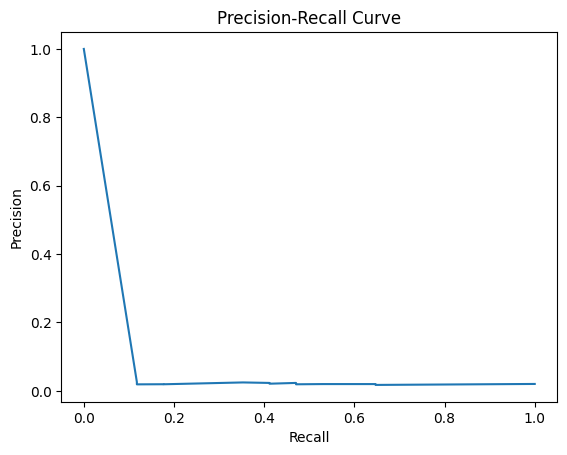

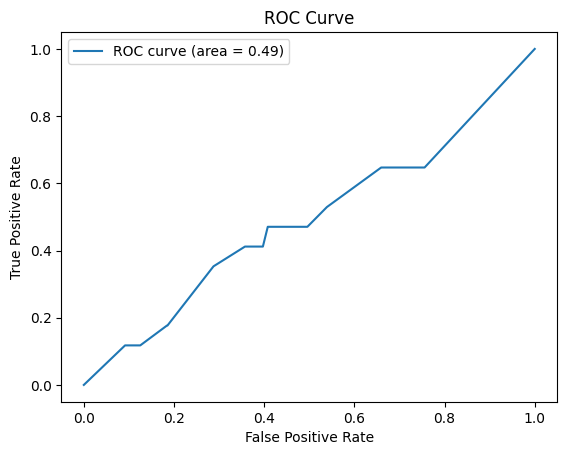

In [238]:
# Test ve Değerlendirme Fonksiyonu
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def test_model(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(12, 8))
    sn.heatmap(df_cm, annot=True, cmap="OrRd", fmt="d", annot_kws={"size": 10}, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))


    # Precision-Recall Eğrisi
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds, pos_label=1)
    plt.plot(recall, precision)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # ROC-AUC Eğrisi
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


# Test Modeli ve Raporlama
test_model(model, test_loader, dataset.classes)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

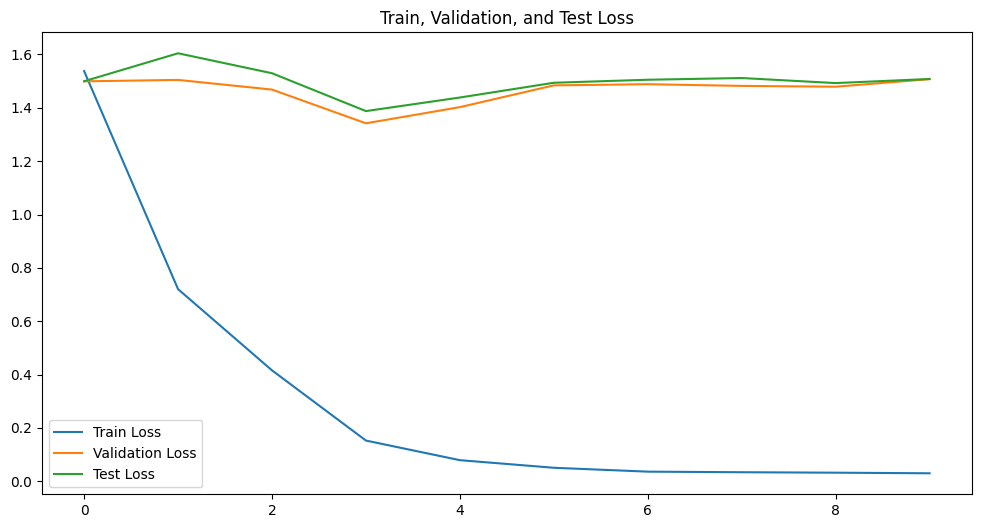

In [248]:
# Kayıp Grafiği
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train, Validation, and Test Loss')
plt.legend()
plt.xlabel


In [247]:
torch.save(model.state_dict(), 'resnet50_61acc.pth')

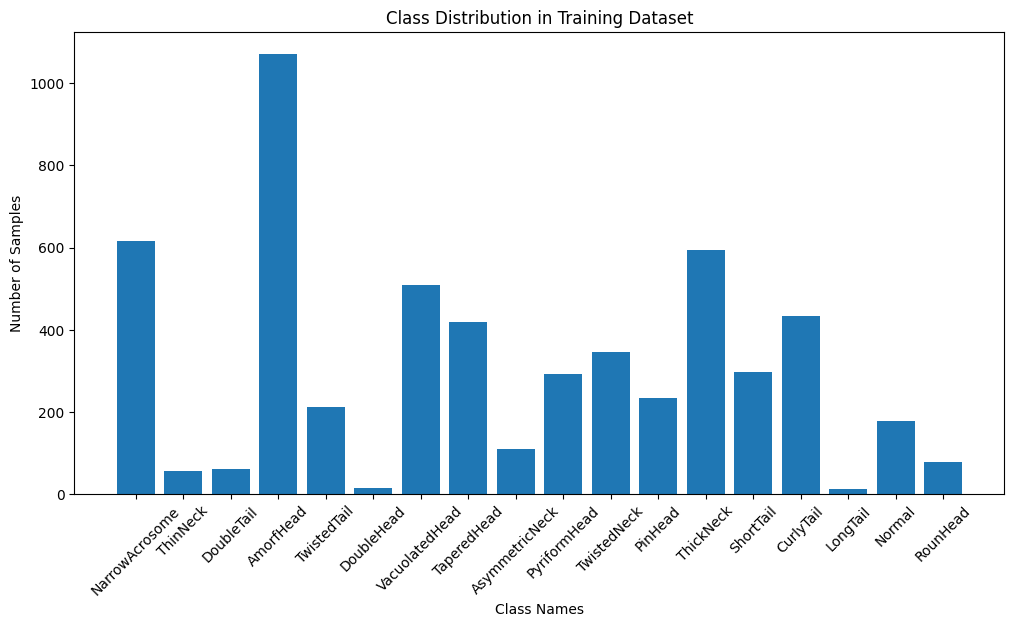

In [250]:
class_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in os.listdir(train_dir)}

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Dataset')
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


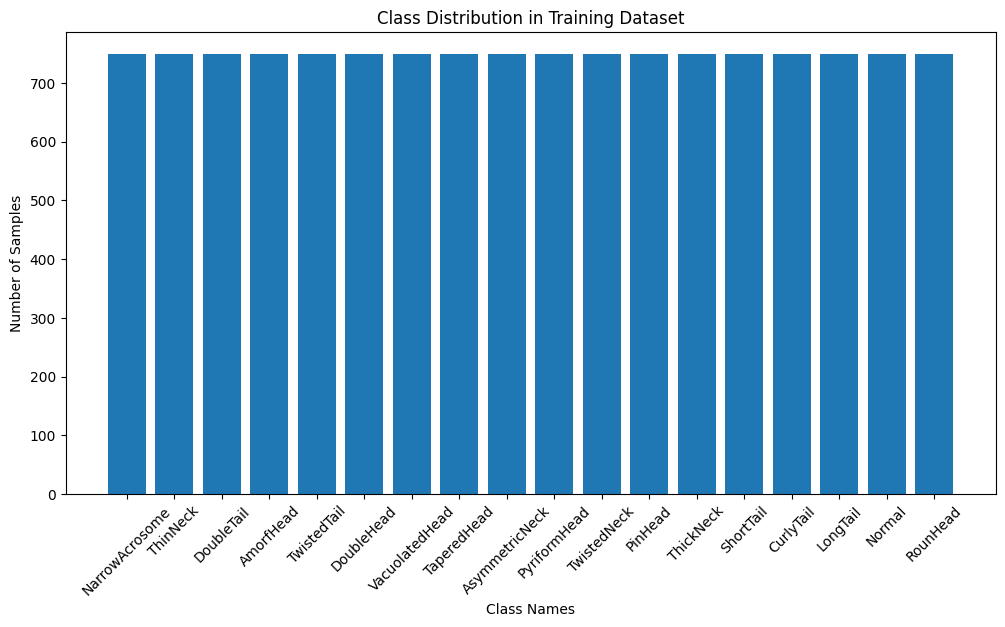

In [251]:
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir)}

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


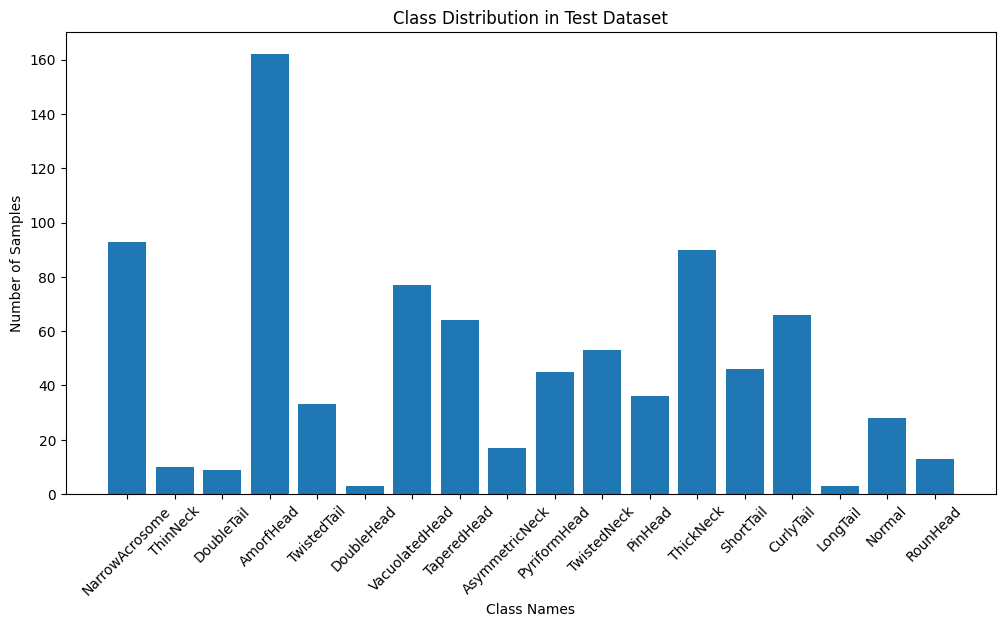

In [252]:
class_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in os.listdir(train_dir)}

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Test Dataset')
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


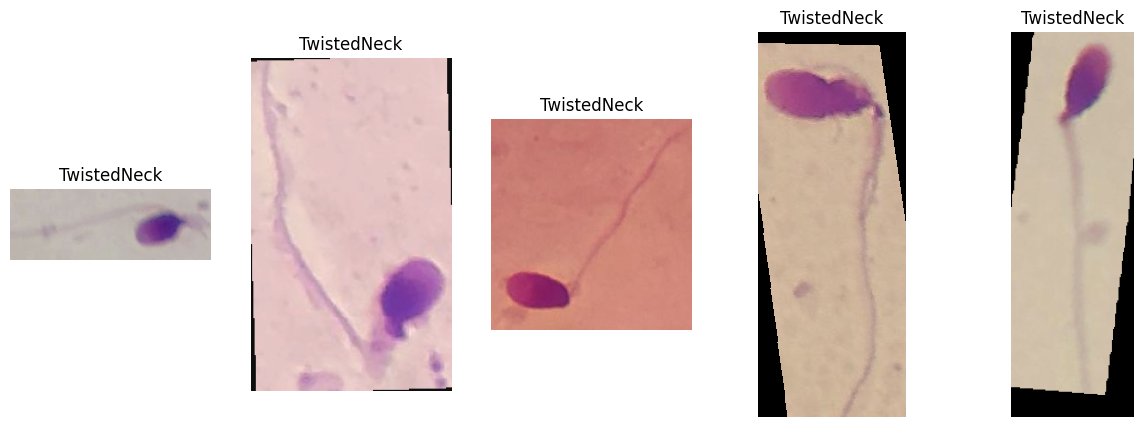

In [255]:
import matplotlib.pyplot as plt
import random
from PIL import Image

class_name = random.choice(os.listdir(train_dir))
class_path = os.path.join(train_dir, class_name)
sample_images = random.sample(os.listdir(class_path), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(class_name)
plt.show()


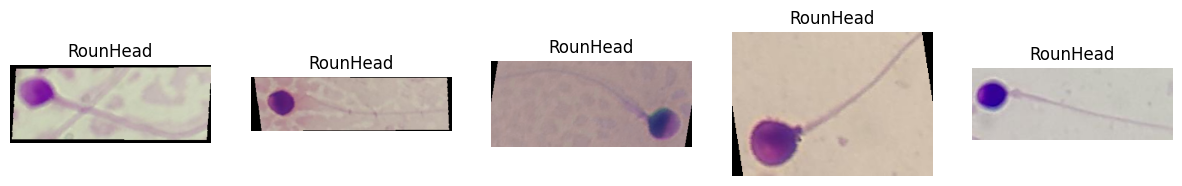

In [256]:
import matplotlib.pyplot as plt
import random
from PIL import Image

class_name = random.choice(os.listdir(train_dir))
class_path = os.path.join(train_dir, class_name)
sample_images = random.sample(os.listdir(class_path), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(class_name)
plt.show()
